In [46]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pre_processing.textProcessing import TextPreProcessor
import nltk
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

# nltk.download('omw-1.4')

### Read Data

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
test_labels = pd.read_csv('../data/test_labels.csv')

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Initial EDA

In [98]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
print('Number of Labels by Label')
train.iloc[:, 2:].sum()

Number of Labels by Label


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

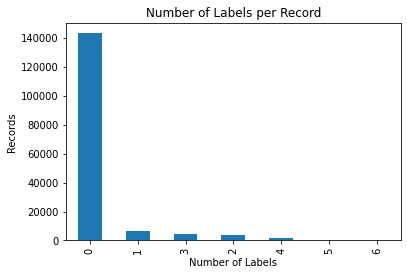

In [7]:
# Check for records that have multiple classifications
classified = train.iloc[:, 2:].sum(axis=1)

mult_class = classified.value_counts()

mult_class.plot(x=mult_class, 
             y=mult_class.values, 
             kind='bar', 
             xlabel='Number of Labels', 
             ylabel='Records')
plt.title('Number of Labels per Record')

pass

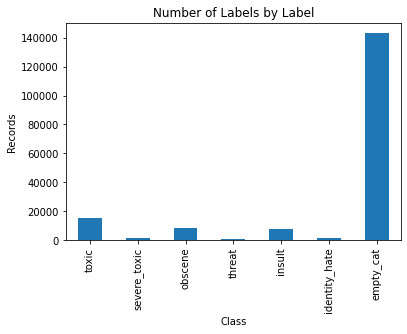

In [8]:
# Check for records that have no classifications and data imbalance
train['empty_cat'] = (classified == 0)
train['empty_cat'] = train['empty_cat'].astype(int)
 
cat_tot = train.iloc[:, 2:].sum()

cat_tot.plot(x=cat_tot, 
             y=cat_tot.values, 
             kind='bar', 
             xlabel='Class', 
             ylabel='Records')
plt.title('Number of Labels by Label')

pass

# Data Preprocessing

### Imbalanced Data: Create Sample

Create a training sample of the following groupings to correct for data imbalance. Split by 50% for each grouping.

* **Toxic** - Records that have label(s).
* **Empty** - Records with no label(s).

In [9]:
toxic = train[train.empty_cat == 0]
empty = train[train.empty_cat == 1]

print('Total Toxic records: ', toxic.shape[0])
print('Total Empty records: ', empty.shape[0])

Total Toxic records:  16225
Total Empty records:  143346


In [10]:
sample = pd.concat([toxic[:16000], empty[:16000]], 
                    ignore_index=True)

sample.shape

(32000, 9)

## Process text for feature-based modeling

In [26]:
def tokenize(text):
    """
    Define a function that take in a text and process the doc
    """
    return TextPreProcessor(text=text, lemma_flag=True, stem_flag=False).process()

### Count Vectorizer

In [13]:
doc = sample.comment_text

In [14]:
# Fit the Count vectorizer
vec_count = CountVectorizer(ngram_range=(1,1),tokenizer=tokenize, min_df=15, max_df=0.9)
vec_count_f = vec_count.fit(doc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [15]:
dtm = vec_count_f.transform(doc)
dtm_df = pd.DataFrame(dtm.toarray())
dtm_df.columns = vec_count_f.get_feature_names()

In [16]:
dtm_df

,_,abandon,abc,abide,ability,able,absence,absolute,absolutely,absurd,...,youre,youth,youtube,youve,yr,yugoslavia,z,zero,zionist,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDF Vectorizer

In [19]:
doc = sample.comment_text

In [20]:
vec_tfidf = TfidfVectorizer(ngram_range=(1,1),tokenizer=tokenize, min_df=15, max_df=0.9)
vec_tfidf_f = vec_count.fit(doc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [21]:
vect = vec_tfidf_f.transform(doc)
vect_df = pd.DataFrame(vect.toarray())
vect_df.columns = vec_tfidf_f.get_feature_names()

In [22]:
vect_df.head()

,able,absolutely,abuse,abusive,academic,accept,access,accord,account,accurate,...,wow,wp,write,wrong,wtf,yeah,year,yes,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Process Text for Modeling

In [24]:
doc = sample.comment_text

In [27]:
# processed_docs = [tokenize(x) for x in doc]
processed_docs = doc.map(lambda x: tokenize(x))

# Create the tokenizer for NN processing
t = Tokenizer()
# Fit the tokenizer on the documents
t.fit_on_texts(processed_docs)
# Transform docs into numeric rep
encoded_docs = t.texts_to_sequences(processed_docs)

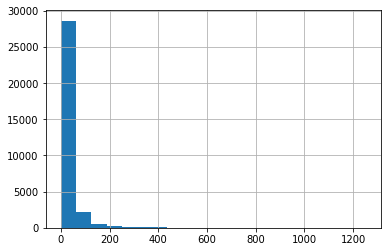

In [28]:
# Find the optimal lengths for padding
pd.Series(encoded_docs).apply(lambda x: len(x)).hist(bins = 20);

In [29]:
max_len = 150 # Most of the documents are less than length 150
padded_doc = pad_sequences(encoded_docs, maxlen = max_len, padding = 'post')

In [30]:
# Print example
print("---Original text---")
print(doc[0])

print('\n---Processed text---')
print(processed_docs[0])

print('\n---Encoded text---')
print(encoded_docs[0])

print('\n---Padded text---')
print(padded_doc[0])

---Original text---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

---Processed text---
['cocksucker', 'piss', 'around', 'work']

---Encoded text---
[306, 550, 204, 47]

---Padded text---
[306 550 204  47   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [31]:
pd.DataFrame(padded_doc).head(100)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,306,550,204,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,195,11,3487,289,637,25900,46,840,5931,17599,...,0,0,0,0,0,0,0,0,0,0
2,1403,39,54,17,10088,82,4194,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,25902,13862,443,3644,9036,25903,3131,126,52,...,0,0,0,0,0,0,0,0,0,0
4,1,2291,288,3409,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30,2539,30,256,2539,2048,6285,3759,17,13,...,0,0,0,0,0,0,0,0,0,0
96,40,896,12,26029,7,3412,415,26030,7,1286,...,0,0,0,0,0,0,0,0,0,0
97,346,2966,1251,27,75,30,274,52,646,974,...,0,0,0,0,0,0,0,0,0,0
98,4,375,517,30,766,9,21,47,190,4,...,0,0,0,0,0,0,0,0,0,0


In [32]:
X_train, X_val, Y_train, Y_val = train_test_split(padded_doc, 
                                                  sample.iloc[:, 2:8], 
                                                  test_size=0.15, 
                                                  random_state=0)

# Baseline Model: Naive Bayes

In [33]:
NBclassifier = MultinomialNB()

for i in Y_train:
    NBclassifier.fit(X_train, Y_train[i])
    pred = NBclassifier.predict(X_val)
    acc = accuracy_score(Y_val[i], pred)
    print(f'{i} Accuracy: {acc}')

toxic Accuracy: 0.5283333333333333
severe_toxic Accuracy: 0.283125
obscene Accuracy: 0.37645833333333334
threat Accuracy: 0.23375
insult Accuracy: 0.36
identity_hate Accuracy: 0.211875


In [25]:
# For exploring cross validation

# score = cross_val_score(classifier, X_train, Y_train[i], scoring='accuracy')

# Random Forest Classifier

In [41]:
RFclassifier = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32, random_state=0)

for i in Y_train:
    RFclassifier.fit(X_train, Y_train[i])
    pred = RFclassifier.predict(X_val)
    acc = accuracy_score(Y_val[i], pred)
    print(f'{i} Accuracy: {acc}')

toxic Accuracy: 0.738125
severe_toxic Accuracy: 0.948125
obscene Accuracy: 0.7995833333333333
threat Accuracy: 0.9839583333333334
insult Accuracy: 0.7779166666666667
identity_hate Accuracy: 0.954375


# Recurrent Neural Network: LSTM


In [42]:
counter = Counter()

# sample.comment_text.str.lower().str.split().apply(counter.update)
processed_docs.apply(counter.update)

print(len(counter))
vocab = len(counter) + 1

62114


In [43]:
input_len = max_len
output_emb = 50

keras.backend.clear_session()
tf.random.set_seed(0)


model = keras.Sequential()

model.add(keras.layers.Embedding(input_dim=vocab, output_dim=output_emb, input_length=input_len))          
          
model.add(keras.layers.LSTM(units=64, dropout=0.2, return_sequences=True))

# model.add(keras.layers.Dense(units=32, activation='relu'))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=6, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           3105750   
                                                                 
 lstm (LSTM)                 (None, 150, 64)           29440     
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 6)                 57606     
                                                                 
Total params: 3,192,796
Trainable params: 3,192,796
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(x = X_train,
                    y = Y_train,
                    epochs=3,
                    batch_size=64,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/3
425/425 [==============================] - 52s 118ms/step - loss: 0.4011 - accuracy: 0.9553 - val_loss: 0.3659 - val_accuracy: 0.9710
Epoch 2/3
425/425 [==============================] - 55s 130ms/step - loss: 0.2525 - accuracy: 0.9711 - val_loss: 0.2203 - val_accuracy: 0.9708
Epoch 3/3
425/425 [==============================] - 56s 133ms/step - loss: 0.2041 - accuracy: 0.9711 - val_loss: 0.2122 - val_accuracy: 0.9710


### Confusion Matrix

# Additional Questions

- Accuracy as a metric
- Limiting vocabulary size, dealing with OOV
- Finalizing vectorizer (countvectorizer, TFIDFvectorizer, Tokenizer())
- Confirm hyperparameters